<a href="https://colab.research.google.com/github/ketkiambekar/stress-detection-PPG-devices/blob/main/Wesad_Stress_Prediction_deeper_model_with_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title mount google drive for access to dataset

import os
from google.colab import auth, drive
drive_mount_path = '/root/data/gdrive'

os.makedirs(drive_mount_path, exist_ok=True)
drive.mount(drive_mount_path)

Mounted at /root/data/gdrive


In [ ]:
#@title Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats
from sklearn import preprocessing
from IPython.display import clear_output 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import LeaveOneGroupOut, learning_curve, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import RBFSampler
from sklearn import metrics

import torch
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modeling Stress based on PPG data using Wesad dataset

## TODO:

1. Filter Dataset with a bandpass filter between [0.4, 0.75] **DONE** Doesn't help by itself
1. Remove SMOTE and instead employ weights in BCE loss function [0.1, 0.9] **Done**
1. Use simple and complex autoencoder to remove noise
    a. First visualize output of autoencoder as compared to input
1. Use BatchNorm with Dropout on all layers **Done**
1. Visualize the output of our CNN by adding a 2 neuron (2-D) layer before the final layer and then plot the outputs with color coding for true and false positives & negatives.

In [ ]:
#@title Utility methods to load and pre-process data to have binary class with groups column for Leave One Group out cross-validation

def combine_dataset_with_group_id(dataset):
  training_data = None 
  X, y, groups = None, None, None
  subjects = list(dataset.keys())

  for s in dataset.keys():
    training_data = dataset[s]
    training_data = np.delete(training_data, np.where(training_data[:,-1] > 4), axis=0) 

    # Set stress label to 1 and rest to 0
    training_data[np.where(training_data[:,-1] < 2),-1] = 0 
    training_data[np.where(training_data[:,-1] > 2), -1] = 0
    training_data[np.where(training_data[:,-1] == 2),-1] = 1
    if X is None:
      X = training_data[:, :-1]
      y = training_data[:,-1]
      groups = np.repeat(subjects.index(s), training_data.shape[0])
    else:
      X = np.concatenate((X, training_data[:, :-1]))
      y = np.concatenate((y, training_data[:, -1]))
      groups = np.concatenate((groups, np.repeat(subjects.index(s), training_data.shape[0])))

  return X, y, groups

def combine_freq_domain_dataset_with_group_id(dataset):
  training_data = None 
  X, y, groups = None, None, None
  subjects = list(dataset.keys())

  for s in dataset.keys():
    training_data = np.array(dataset[s][2]).T # FFT data
    labels = np.copy(dataset[s][3])
    drop_indexes = np.where(labels > 4)
    training_data = np.delete(training_data, drop_indexes, axis=0) 
    labels = np.delete(labels, drop_indexes, axis=0)
    # Set stress label to 1 and rest to 0
    labels[np.where(labels < 2)] = 0 
    labels[np.where(labels > 2)] = 0
    labels[np.where(labels == 2)] = 1
    if X is None:
      X = training_data
      y = labels
      groups = np.repeat(subjects.index(s), training_data.shape[0])
    else:
      X = np.concatenate((X, training_data))
      y = np.concatenate((y, labels))
      groups = np.concatenate((groups, np.repeat(subjects.index(s), training_data.shape[0])))
  return X, y, groups

def get_freq_domain_data():
  with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/freq-domain.pkl', 'rb') as fp:
      freq_features = pickle.load(fp)
  X, y, groups = combine_freq_domain_dataset_with_group_id(freq_features)
  X = 20*np.log10(np.abs(X))
  scaler = RobustScaler()
  scaler.fit(X)
  X = scaler.transform(X)
  return X, y, groups, scaler

def get_time_domain_data():
  with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/processed-dictionary.pkl', 'rb') as fp:
    dataset = pickle.load(fp)
  X, y, groups = combine_dataset_with_group_id(dataset)
  scaler = RobustScaler()
  scaler.fit(X)
  X = scaler.transform(X)
  return X, y, groups, scaler


In [ ]:
#@title Bandpass filtering utility function
from scipy import signal

def bp_filter(data, freq=64, filter=[0.7, 3.5]):
  sos = signal.butter(4, filter, 'bandpass', fs=freq, output='sos')
  return signal.sosfilt(sos, data)

In [ ]:
#@title Get raw data and filter it
%skip
X, y, groups, scaler = get_time_domain_data()
X = bp_filter(X) # only for time domain data

In [ ]:
#@title run only if you want to use peaks as opposed to raw signals
def peaks(s):
  p = signal.find_peaks(s, distance=25, height=[0], prominence=[0.4])[0]
  peaks = np.zeros_like(s)
  peaks[p] = 1
  return peaks

In [ ]:
#@title Setting up train & test data with leave one group out cross validation
%skip
logo = LeaveOneGroupOut()
train_idx, test_idx = next(logo.split(X, y, groups))
X_train, y_train, train_groups = X[train_idx], y[train_idx], groups[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
train_idx, val_idx = next(logo.split(X_train, y_train, train_groups))
X_val, y_val = X_train[val_idx], y_train[val_idx]
X_train, y_train, train_groups = X_train[train_idx], y_train[train_idx], train_groups[train_idx]

In [ ]:
#@title caching dataset on gdrive
%skip
split_dataset = {'train': [X_train, y_train, train_groups], 'val': [X_val, y_val], 'test': [X_test, y_test]}
with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/train_val_test_split.pkl', 'wb') as fp:
    pickle.dump(split_dataset, fp, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
#@title Load train, val and test set cached on gdrive
with open('/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/train_val_test_split.pkl', 'rb') as fp:
    split_dataset = pickle.load(fp) 
X_train, y_train, train_groups = split_dataset['train']
X_val, y_val = split_dataset['val']
X_test, y_test = split_dataset['test']

In [ ]:
#@title training hyperparameters
num_epochs = 500
capacity = 10
learning_rate = 1e-3
batch_size=512
# Only relevant for ResNext
config = {"cardinality":32, "input_shape": (1, 1, 512), "capacity":32, "base_channels":8, "depth":[3,4, 6, 3]}


In [ ]:
#@title Smote based over sampling
from imblearn.over_sampling import SMOTE

def balance_dataset(X, Y, groups):
  X_train_res, y_train_res, train_groups_res = None, None, None
  subjects = np.unique(groups)
  for g in np.unique(groups):
    idx = np.where(groups == g)
    sm = SMOTE(random_state=2)
    x, y = sm.fit_sample(X[idx], Y[idx])
    if X_train_res is None:
      X_train_res, y_train_res = x, y
      train_groups_res = np.repeat(g, x.shape[0])
    else:
      X_train_res = np.concatenate((X_train_res, x), axis=0)
      y_train_res = np.concatenate((y_train_res, y), axis=0)
      train_groups_res = np.concatenate((train_groups_res, np.repeat(g, x.shape[0])), axis=0)
  return X_train_res, y_train_res, train_groups
X_train_res, y_train_res, train_groups_res = balance_dataset(X_train, y_train, train_groups)
clear_output()

In [ ]:
#@title reshape data for CNN and generate batches
X_train_res = torch.Tensor(X_train_res)
X_train_reshaped = X_train_res.reshape(X_train_res.shape[0], 1, X_train_res.shape[1])
y_train_res = torch.Tensor(y_train_res)
X_val = torch.Tensor(X_val)
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
y_val = torch.Tensor(y_val)
X_train_batched = X_train_reshaped[:(X_train_reshaped.size()[0]//batch_size) * batch_size].reshape(X_train_reshaped.size()[0]//batch_size, batch_size, 1, 512)
y_train_batched = y_train_res[:(X_train_reshaped.size()[0]//batch_size) * batch_size].reshape(X_train_reshaped.size()[0]//batch_size, batch_size, 1)
X_train_batched = X_train_batched.to(device)
y_train_batched = y_train_batched.to(device)

X_val_batched = X_val_reshaped[:(X_val_reshaped.size()[0]//batch_size) * batch_size].reshape(X_val_reshaped.size()[0]//batch_size, batch_size, 1, 512)
y_val_batched = y_val[:(X_val_reshaped.size()[0]//batch_size) * batch_size].reshape(X_val_reshaped.size()[0]//batch_size, batch_size, 1)
X_val_batched = X_val_batched.to(device)
y_val_batched = y_val_batched.to(device)

In [ ]:
#@title A simple CNN based Binary Classification model
class stresspredictor(nn.Module):
    def __init__(self, capacity, dropout=0.05):
        super(stresspredictor, self).__init__()
        self.capacity = capacity
        self.dropout_rate = dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=capacity, kernel_size=4, stride=2, padding=1),  # b, c x 38
            nn.BatchNorm1d(capacity),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Conv1d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1),  # b, 2*c, 19
            nn.BatchNorm1d(capacity*2),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Conv1d(in_channels=capacity*2, out_channels=capacity*3, kernel_size=4, stride=2, padding=1),  # b, 2*c, 19
            nn.BatchNorm1d(capacity*3),
            nn.ReLU(True),
    
            nn.Dropout(self.dropout_rate),
            nn.Conv1d(in_channels=capacity*3, out_channels=capacity*4, kernel_size=4, stride=2, padding=1),  # b, 2*c, 19
            nn.BatchNorm1d(capacity*4),
            nn.ReLU(True),
            
            nn.Dropout(self.dropout_rate),
            nn.Conv1d(in_channels=capacity*4, out_channels=capacity*5, kernel_size=4, stride=2, padding=1),  # b, 2*c, 19
            nn.ReLU(True),
            nn.AvgPool1d(4), # b, 4*c, 16
            nn.Flatten(),
        )
        with torch.no_grad():
          op = self.encoder(torch.rand(1, 1,512))
        self.linear = nn.Sequential(
          nn.Linear(op.size()[-1], capacity),
          nn.ReLU(True),
          nn.Dropout(self.dropout_rate),

          nn.Linear(capacity, 2),
          
          nn.ReLU(True),
        )

        self.final = nn.Linear(2, 1)
        #for param in self.encoder.parameters():
        #  param.requires_grad = False

    def forward(self, x):
        relu = nn.ReLU()
        dropout = nn.Dropout(self.dropout_rate)
        x = self.encoder(x)
        x = self.linear(x)
        y_hat = self.final(x)
        return y_hat

In [ ]:
#@title ResNext
def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        m.bias.data.zero_()


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride, cardinality):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = cardinality * out_channels // self.expansion

        self.conv1 = nn.Conv1d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm1d(bottleneck_channels)

        self.conv2 = nn.Conv1d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 1x3 conv
            padding=1,
            groups=cardinality,
            bias=False)
        self.bn2 = nn.BatchNorm1d(bottleneck_channels)

        self.conv3 = nn.Conv1d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv1d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm1d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y

class ResNext(nn.Module):
    def __init__(self, config):
        super(ResNext, self).__init__()

        input_shape = config['input_shape']
        capacity = config['capacity']

        base_channels = config['base_channels']
        self.cardinality = config['cardinality']
        self.depth = config['depth']
        assert len(self.depth) <=4
        block = BottleneckBlock

        n_channels = [
            base_channels, base_channels * block.expansion,
            base_channels * 2 * block.expansion,
            base_channels * 3 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv1d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm1d(n_channels[0])

        self.stages = nn.Sequential()
        for d, width in enumerate(self.depth):
          self.stages.add_module("stage {}".format(d+1), self._make_stage(n_channels[d], n_channels[d+1], width, stride=4))

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]
 
        self.fc = nn.Linear(self.feature_size, capacity)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name,
                    BottleneckBlock(
                        in_channels,
                        out_channels,
                        stride,  # downsample
                        self.cardinality))
            else:
                stage.add_module(
                    block_name,
                    BottleneckBlock(
                        out_channels,
                        out_channels,
                        1,  # no downsampling
                        self.cardinality))
        return stage

    def _forward_conv(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stages(x)
        x = F.adaptive_avg_pool1d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
#@title ResNext based model
class stresspredictorResNext(nn.Module):
    def __init__(self, encoder_config, dropout=0.0):
        super(stresspredictorResNext, self).__init__()
        self.encoder_config = encoder_config
        self.encoder = ResNext(self.encoder_config)
        self.dropout = dropout
        self.l1 = nn.Linear(encoder_config['capacity'], 1)
        nn.init.kaiming_normal_(self.l1.weight, nonlinearity='sigmoid')
        #for param in self.encoder.parameters():
        #  param.requires_grad = False

    def forward(self, x):
        relu = nn.ReLU()
        dropout = nn.Dropout(self.dropout)
        x = relu(self.encoder(x))
        x = self.l1(x)
        return x

In [ ]:
#@title initialize the stress prediction model
from torchsummary import summary

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv1d: 
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.ConvTranspose1d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
# Simple model
sp = stresspredictor(capacity, dropout=0.2)
sp.apply(init_weights)
# complex ResNext model
#sp = stresspredictorResNext(config)

sp.to(device)
summary(sp, (1, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 10, 256]              50
       BatchNorm1d-2              [-1, 10, 256]              20
              ReLU-3              [-1, 10, 256]               0
           Dropout-4              [-1, 10, 256]               0
            Conv1d-5              [-1, 20, 128]             820
       BatchNorm1d-6              [-1, 20, 128]              40
              ReLU-7              [-1, 20, 128]               0
           Dropout-8              [-1, 20, 128]               0
            Conv1d-9               [-1, 30, 64]           2,430
      BatchNorm1d-10               [-1, 30, 64]              60
             ReLU-11               [-1, 30, 64]               0
          Dropout-12               [-1, 30, 64]               0
           Conv1d-13               [-1, 40, 32]           4,840
      BatchNorm1d-14               [-1,

In [ ]:
#@title Model Checkpoint path - make sure it's unique for each model
sp_model_ckpt_path = "/root/data/gdrive/MyDrive/PPG datasets - pandas csv format/WESAD/vish_sp_cnn_5layer_bn_relu.pt"

In [ ]:
#@title utility function to plot gradients
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")

In [ ]:
#@title utility function to get accuracy and roc
def get_auc_accuracy(pred, target):
  y_pred = nn.Sigmoid()(pred)
  fpr, tpr, thresholds = metrics.roc_curve(target, y_pred)
  roc_auc = metrics.auc(fpr, tpr)
  gmeans = np.sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)
  pred_binary = (y_pred > thresholds[ix]).numpy().astype(int)
  accuracy = metrics.accuracy_score(target, pred_binary)
  return (np.nan_to_num(roc_auc), accuracy)

In [ ]:
#@title Train the stress prediction model with binary cross entropy loss
optimizer = torch.optim.Adam(params=sp.parameters(), lr=learning_rate, weight_decay=5e-5)
loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
#loss_fn.register_full_backward_hook(lambda mod, grad_ip, grad_op: print(grad_ip))
train_loss_avg = []
val_loss_avg = np.zeros((num_epochs,3))
print('Training ...')
for epoch in range(num_epochs):
    # set to training mode
    sp.train()
    train_loss_avg.append(0)
    train_rand_idx = torch.randperm(X_train_batched.size()[0])
    X_train_ep, y_train_ep = X_train_batched[train_rand_idx], y_train_batched[train_rand_idx]

    val_rand_idx = torch.randperm(X_val_batched.size()[0])
    X_val_ep, y_val_ep = X_val_batched[val_rand_idx], y_val_batched[val_rand_idx]
    num_batches = 0
    for b in range(X_train_ep.size()[0]):
        curr_batch = X_train_ep[b].to(device)
        y_train = y_train_ep[b].to(device)
        # vae reconstruction
        y_hat = sp(curr_batch)
        # reconstruction error
        loss = loss_fn(y_hat, y_train)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
       
    train_loss_avg[-1] /= num_batches
    
    sp.eval()
    with torch.no_grad():
      val_loss = 0.
      for b in range(X_val_ep.size()[0]):
        curr_batch = X_val_ep[b].to(device)
        y_val_local = y_val_ep[b].to(device)
        # vae reconstruction
        y_hat = sp(curr_batch)
        # reconstruction error
        loss = loss_fn(y_hat, y_val_local)
        # reconstruction error
        val_loss += loss
      val_loss /= X_val_ep.size()[0]
      auc, acc = get_auc_accuracy(y_hat.detach().cpu(), y_val_local.detach().cpu())
      val_loss_avg[epoch] = [auc, acc, val_loss.item()]
    if epoch > 50 and np.max(val_loss_avg[50:epoch,0]) <= val_loss_avg[epoch,0]:
      print("saving model")
      torch.save(sp.state_dict(), sp_model_ckpt_path)
    print('Epoch [%d / %d] train BCE Loss: %f, val auc: %f, accuracy: %f, BCE Loss: %f' % 
            (epoch+1, num_epochs, train_loss_avg[-1], val_loss_avg[epoch,0], val_loss_avg[epoch,1],  val_loss_avg[epoch,2]))

Training ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Epoch [1 / 500] train BCE Loss: 355.098590, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 358.031372
Epoch [2 / 500] train BCE Loss: 354.966507, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 357.561615
Epoch [3 / 500] train BCE Loss: 355.258703, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 356.976562
Epoch [4 / 500] train BCE Loss: 355.131583, val auc: 0.500000, accuracy: 0.398438, BCE Loss: 357.451630
Epoch [5 / 500] train BCE Loss: 354.957457, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 357.170685
Epoch [6 / 500] train BCE Loss: 355.015435, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 355.764069
Epoch [7 / 500] train BCE Loss: 355.287882, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 356.056305
Epoch [8 / 500] train BCE Loss: 355.036180, val auc: 0.000000, accuracy: 1.000000, BCE Loss: 356.263763
Epoch [9 / 500] train BCE Loss: 354.931801, val auc: 0.500000, accuracy: 0.398438, BCE Loss: 355.853668
Epoch [10 / 500] train BCE Loss: 354.993418, val auc: 0.000000, 

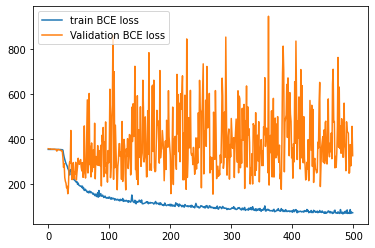

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss_avg, label="train BCE loss")
ax.plot(np.array(val_loss_avg)[:,-1], label="Validation BCE loss")
#ax.set_yscale('log')
ax.legend()
plt.show()

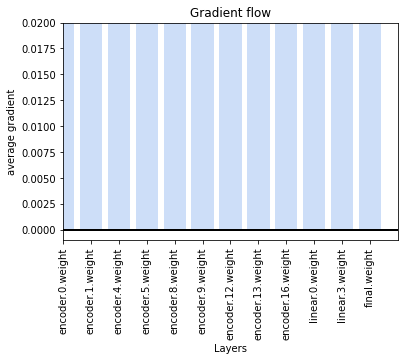

In [ ]:
plot_grad_flow(sp.named_parameters())

In [ ]:
sp_test = stresspredictor(capacity)
sp_test.load_state_dict(torch.load(sp_model_ckpt_path))
sp_test.to(device)

stresspredictor(
  (dropout): Dropout(p=0.05, inplace=False)
  (encoder): Sequential(
    (0): Conv1d(1, 10, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv1d(10, 20, kernel_size=(4,), stride=(2,), padding=(1,))
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Conv1d(20, 30, kernel_size=(4,), stride=(2,), padding=(1,))
    (9): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Conv1d(30, 40, kernel_size=(4,), stride=(2,), padding=(1,))
    (13): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.05, inplace=False)
    (

In [ ]:

sp_test.eval()
y_val_pred = sp_test(X_val_reshaped.to(device))
y_train_pred = sp_test(X_train_reshaped.to(device))

In [ ]:
y_val_pred = nn.Sigmoid()(y_val_pred)
y_train_pred = nn.Sigmoid()(y_train_pred)

In [ ]:
def plot_roc(target, pred, title):
  fpr, tpr, thresholds = metrics.roc_curve(target, pred)
  roc_auc = metrics.auc(fpr, tpr)
  gmeans = np.sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic on {} Set'.format(title))
  plt.legend(loc="lower right")
  plt.show()
  return thresholds[ix]


def plot_roc_auc_acc(train, train_pred, val, val_pred):
  threshold = plot_roc(train,train_pred, "Train")
  pred_binary = (train_pred > threshold).detach().cpu().numpy().astype(int)
  print("Train accuracy ", metrics.accuracy_score(train, pred_binary))
  print("Train CF Matrix \n", metrics.confusion_matrix(train, pred_binary))
  threshold_val = plot_roc(val, val_pred, "Val")
  pred_binary_val = (val_pred > threshold_val).detach().cpu().numpy().astype(int)
  print("Val accuracy ", metrics.accuracy_score(val, pred_binary_val))
  print("Val CF Matrix \n", metrics.confusion_matrix(val, pred_binary_val))


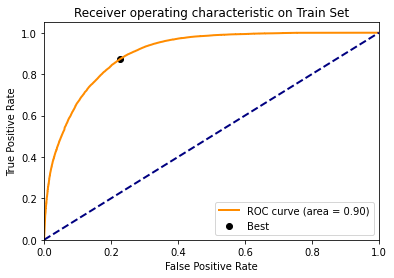

Train accuracy  0.8230240010052777
Train CF Matrix 
 [[24618  7214]
 [ 4053 27779]]


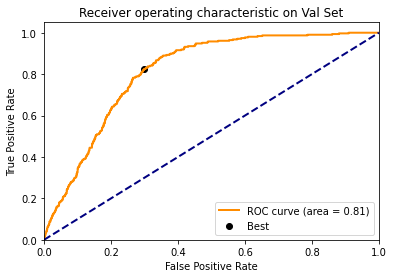

Val accuracy  0.7136608344549125
Val CF Matrix 
 [[1868  796]
 [  55  253]]


In [ ]:
plot_roc_auc_acc(y_train_res.detach().cpu(), y_train_pred.detach().cpu(), y_val.detach().cpu(), y_val_pred.detach().cpu())